In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# The example picture


- this is a picture of my fish tank with a calibration chessboard picture

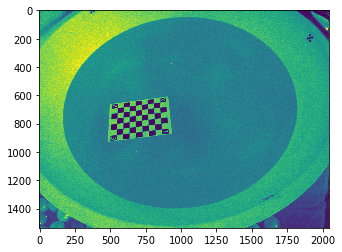

In [2]:
img = np.array(Image.open('example.tiff').convert("L"))
plt.imshow(img)
plt.show()

# Measure Points on the Image

- In a image, parallel lines in may not be parallel 
- We want to recover the parallel property, which means we want our image to be the result of a **affine transformation**, instead of a projective transformation
- We do this by find the coordinates of the **line at infinity**, $l_\infty$, and the $3 \times 3$ matrix that transforms this line to $(0, 0, 1)$
- How do we find the $l_\infty$? Two parallel line in real life meet in an **infinity point** on the image. Two infinity points gives us the $l_\infty$.
- We are now aiming at finding the meeting point of line 13 & line 2x, as well as the meeting point of line 23 and line x1.

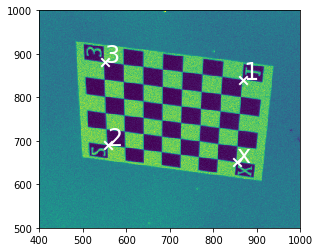

In [3]:
px, p1, p2, p3 = np.array([
    [854, 652],
    [868, 841],
    [557, 691],
    [550, 881],
])

points = [px, p1, p2, p3]
name = ["x", "1", "2", "3"]

for n,p in zip(name, points):
    plt.scatter(*p, color='w', marker='x', lw=2, s=72)
    plt.text(*p, n, color='w', fontsize=24)
plt.imshow(img)
plt.xlim(400, 1000)
plt.ylim(500, 1000)
plt.show()

# Get points at infinity

- The homogeneous representation of point (x, y) is (x, y, 1)
- The line determined by two points in their homogeneous coordinates, $\mathbf{p}_1$ and $\mathbf{p}_2$, is given conveniently by $\mathbf{line} = \mathbf{p}_1 \times \mathbf{p}_2$
- For any point $\mathbf{p}$ on this line, we have $\mathbf{p} \cdot \mathbf{line} = 0$

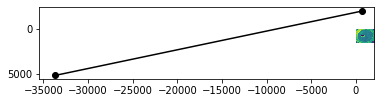

[1.11847668e-04 5.33322067e-04 1.00000000e+00]


In [4]:
pxh, p1h, p2h, p3h = [np.hstack((p, 1)) for p in (points)]
l13 = np.cross(p1h, p3h)
l2x = np.cross(p2h, pxh)
l1x = np.cross(p1h, pxh)
l23 = np.cross(p2h, p3h)

p_inf_1h = np.cross(l13, l2x)
p_inf_1 = (p_inf_1h / p_inf_1h[-1])[:2]
p_inf_2h = np.cross(l1x, l23)
p_inf_2 = (p_inf_2h / p_inf_2h[-1])[:2]

plt.imshow(img)
plt.scatter(*p_inf_1, color='k')
plt.scatter(*p_inf_2, color='k')
plt.plot(*np.vstack((p_inf_1, p_inf_2)).T, color='k')
plt.show()

l_inf = np.cross(p_inf_1h, p_inf_2h)
l_inf = l_inf / l_inf[-1]
print(l_inf)

# Affine rectified image

- If we apply the transformation obtained from $l_\infty$, we get a new image
- In such image, parallel line in real life is parallel in the image

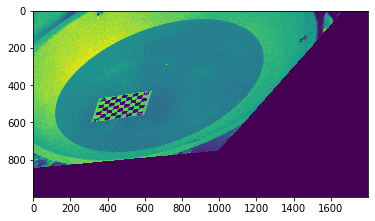

In [5]:
H = np.vstack(([1, 0, 0], [0, 1, 0], l_inf))
affine = cv2.warpPerspective(img, H, (1800, 1000))
plt.imshow(affine)
plt.show()
plt.close()

# Measure Coordinates in the Affined transformed Image


- Now we want to recover such information: perpendicular lines in real life should be perpendicular in the image
- This is to say, we want our image to be the result of, not an affine transformation, but a similar transformation.
- We do this by specifying two perpendicular pairs in the image. In this case, it is line x1 & x2, and line 2z & 3y.

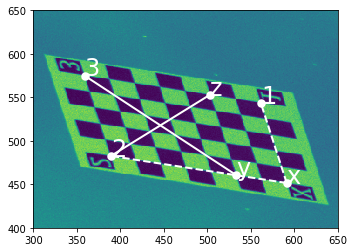

In [6]:
px_Ah = np.array([591.5, 451.5, 1])
p1_Ah = np.array([561.7, 543.5, 1])
p2_Ah = np.array([389.3, 482.6, 1])
p3_Ah = np.array([359, 575, 1])
py_Ah = np.array([533.4, 460.6, 1])
pz_Ah = np.array([503.3, 553, 1])

points_A = [px_Ah[:2], p1_Ah[:2], p2_Ah[:2], p3_Ah[:2], py_Ah[:2], pz_Ah[:2]]
names_A = ['x', '1', '2', '3', 'y', 'z']

for p, n in zip(points_A, names_A):
    plt.scatter(*p, color='w', marker='o', lw=2, s=42)
    plt.text(*p, n, color='w', fontsize=24)
plt.plot(*np.vstack((px_Ah[:2], p1_Ah[:2])).T, '--', color='w', lw=2)
plt.plot(*np.vstack((px_Ah[:2], p2_Ah[:2])).T, '--', color='w', lw=2)

plt.plot(*np.vstack((p3_Ah[:2], py_Ah[:2])).T, color='w', lw=2)
plt.plot(*np.vstack((p2_Ah[:2], pz_Ah[:2])).T, color='w', lw=2)

plt.imshow(affine)
plt.xlim(300, 650)
plt.ylim(400, 650)
plt.show()

# Calculate the homography from affine image to similar image


- Notice the result is **NOT** equivelant to an image taken from a top view, even though it looks very similar. (Image from the top view is still a projective transformation)
- It is the similar transformation of the plane of the chessboard. In real 3D space, the distances and angles are not invariant if they were not on the same plane of the chessboard.

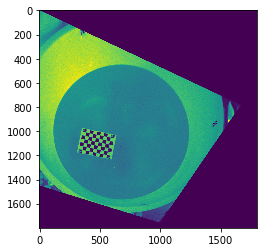

In [7]:
# first orthogonal pair, x1 & x2
lx2_Ah = np.cross(px_Ah, p2_Ah)
lx1_Ah = np.cross(px_Ah, p1_Ah)
lx2_A = (lx2_Ah / lx2_Ah[-1])[:2]
lx1_A = (lx1_Ah / lx1_Ah[-1])[:2]

# second orthogonal pair, 2z & 3y
l2z_Ah = np.cross(p2_Ah, pz_Ah)
l3y_Ah = np.cross(p3_Ah, py_Ah)
l2z_A = (l2z_Ah / l2z_Ah[-1])[:2]
l3y_A = (l3y_Ah / l3y_Ah[-1])[:2]

# Solve for M(2, 3) * S(3, 1) == 0
M = np.empty((2, 3))

m, l = lx1_A, lx2_A
M[0][0] = m[0]*l[0]
M[0][1] = m[0]*l[1] + m[1]*l[0]
M[0][2] = m[1]*l[1]

m, l = l2z_A, l3y_A
M[1][0] = m[0]*l[0]
M[1][1] = m[0]*l[1] + m[1]*l[0]
M[1][2] = m[1]*l[1]

s11, s12 = np.linalg.solve(M[:, :2], -M[:, -1])

S = np.array([
    [s11, s12],
    [s12, 1],
])  # we set s22 to be 1

S = S / max(s11, 1)  # force image to be expanded

K = np.linalg.cholesky(S)  # affinity component K in the bible
HA = np.array([
    [K[0, 0], K[0, 1], 0],
    [K[1, 0], K[1, 1], 0],
    [0, 0, 1],
]) # Homography for Affinity

similar = cv2.warpPerspective(affine, np.linalg.inv(HA), (1800, 1800))
plt.imshow(similar)
plt.show()

img_similar = Image.fromarray(similar)
img_similar.save('similar.png')

# Composing the transformation


In the end we get the matrix `Hs` that transforms a projective image to a similar image

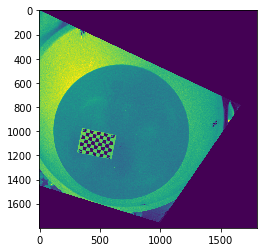

In [8]:
Hs = np.linalg.inv(HA) @ H
test = cv2.warpPerspective(img, Hs, (1800, 1800))
plt.imshow(test)
plt.show()